# Using a mean variance approach to create pipe risk alerts
This project was for a water utilities company who needed a way to see anomalous behaviour on their clean water network. 
They needed to:
1. bring together timeseries data (flow and pressure data) from multiple sources into one platform, 
2. visualise it on a geospatial view, 
3. raise anomaly alerts on the flow and pressure data, and 
4. infer those alerts onto hydraulically linked pipes. 

## Prerequisites and Solution outline
### Prerequisites
- GIS location data of all clean water assets (pipes, meter, valves, etc.)
- NetworkX graph object built from GIS data (pipes are edges and other assets are nodes)
- Current and historic timeseries data from flow and pressure sensors

### Solution outline
- Use historical flow and pressure data to learn mean and standard deviation for every 15min timestamp bucket broken up into weekdays and weekends.
- Calculate z-scores for live data according to the timestamp and day bucket it falls into.
- Give the live data a status (green, yellow, amber, red) according to the z-score based on z-score thresholds (e.g.: +-1 green, +-2 yellow, +-3 amber, +-4 red).
- For measurement devices that have both flow and pressure sensors aggregate flow and pressure z-scores by using a Euclidean distance in a flow and pressure z-score space. This results in a higher z-score if both flow and pressure are abnormal and will never be less than the highest z-score.
- Give the measurement devices a status (green, yellow, amber, red) according to the z-score
- Use the graph object to associate hydraulicly linked measurement devices to every pipe and calculate the distance the measurement device is away from the pipe.
- Create a pipe z-score with an exponentially decaying by distance weighted average of the associated measurement devices.
- Give the pipes a status (green, yellow, amber, red) according to the z-scores. 

## Testing and parameter tuning
The above algorithm was optimised for major events like bursts as these cost the water utility the most amount of money per year. A historical list of burst events was used to tune the algorithm parameters in order to reduce false positives but ensure there were no false negatives (no missed bursts).  

## Example of a burst alert on GIS web app
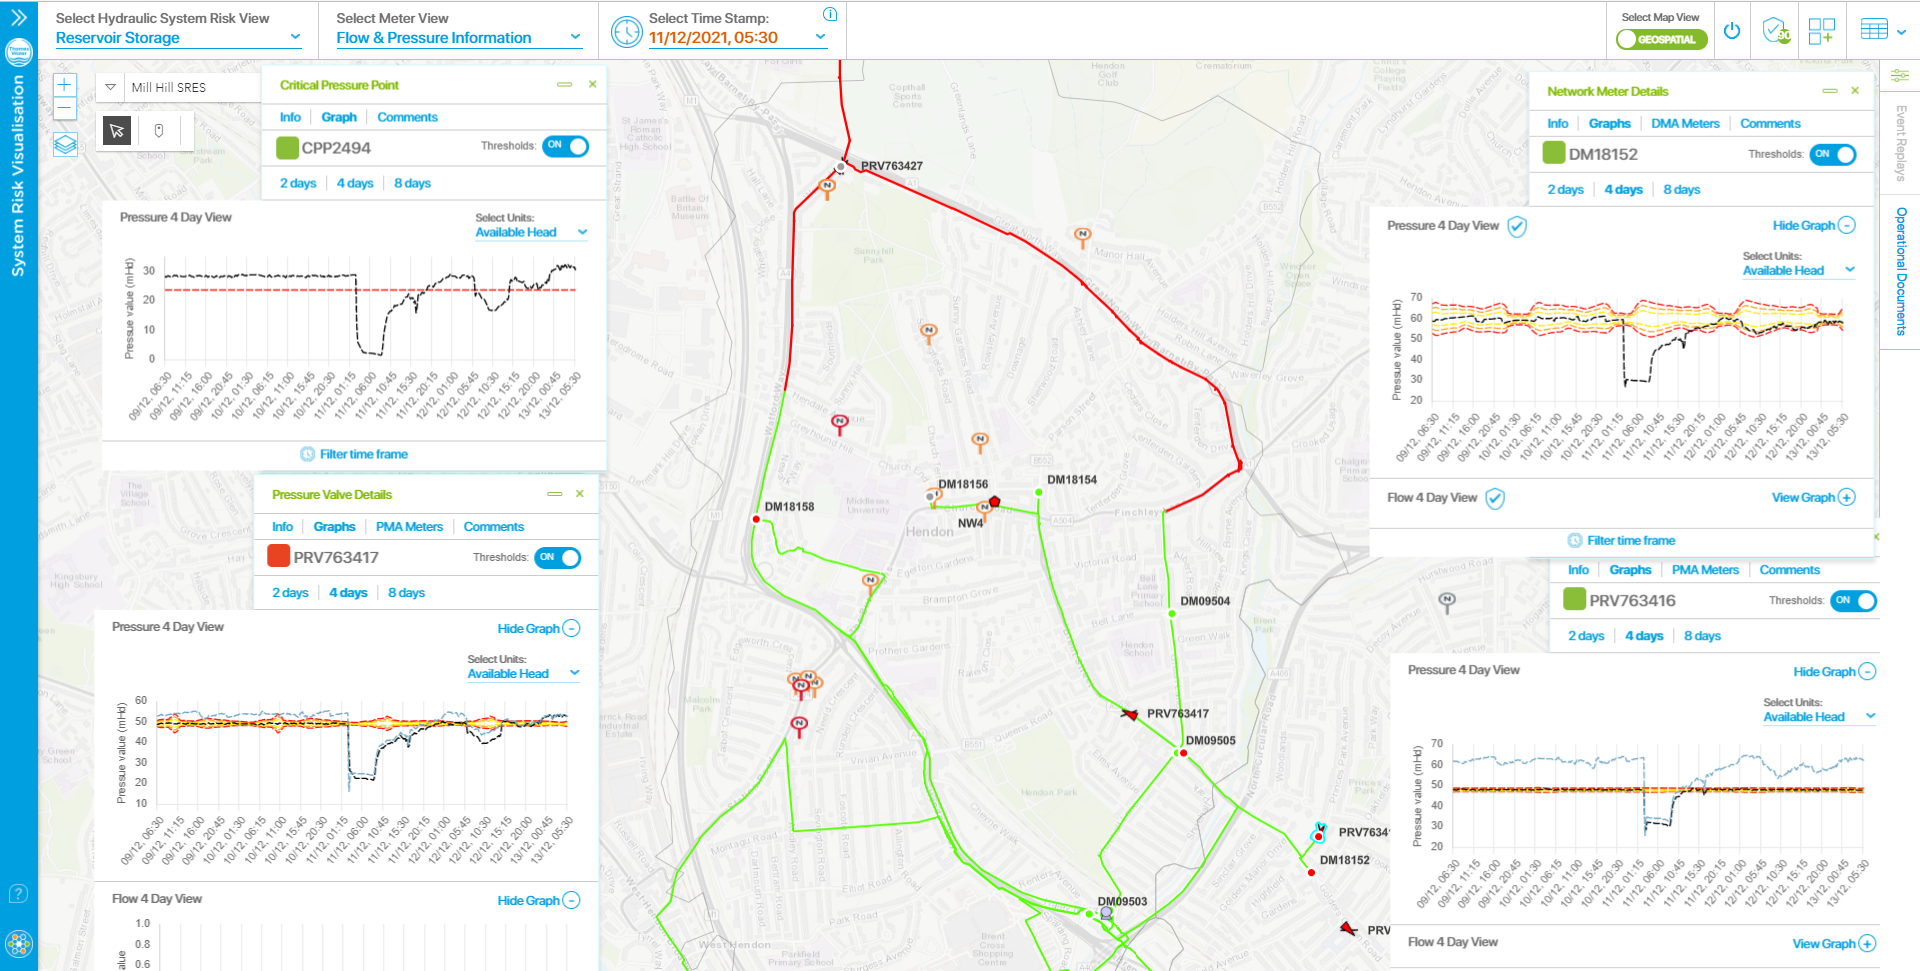

## Solution details
### Mean and standard deviation for every 15min timestamp
One year of historical data is used to calculate a mean and standard deviation for every 15min timestamp in a day for weekdays and weekends. This was done because the data has a deterministic seasonality that is based on customers usage patterns and so by bucketing the data into 15min windows, weekdays and weekends the data in each bucket should be able to be more precisely modelled by a normal distribution. The biggest problem with this approach is that it is very sensitive to periods of large changes in the historic data because that can result in very large variances and so very wide and not useful z-score thresholds. Thus, a lot of work had to be done to ensure that the historical data was cleaned to only contain data relevant to normal network operation. This was done a few different ways, firstly general anomaly and outlier removal, then erroneous data removal based on nearby measuring devices and hydraulic network limits and finally user and business input. Example of z-score thresholds created by this:
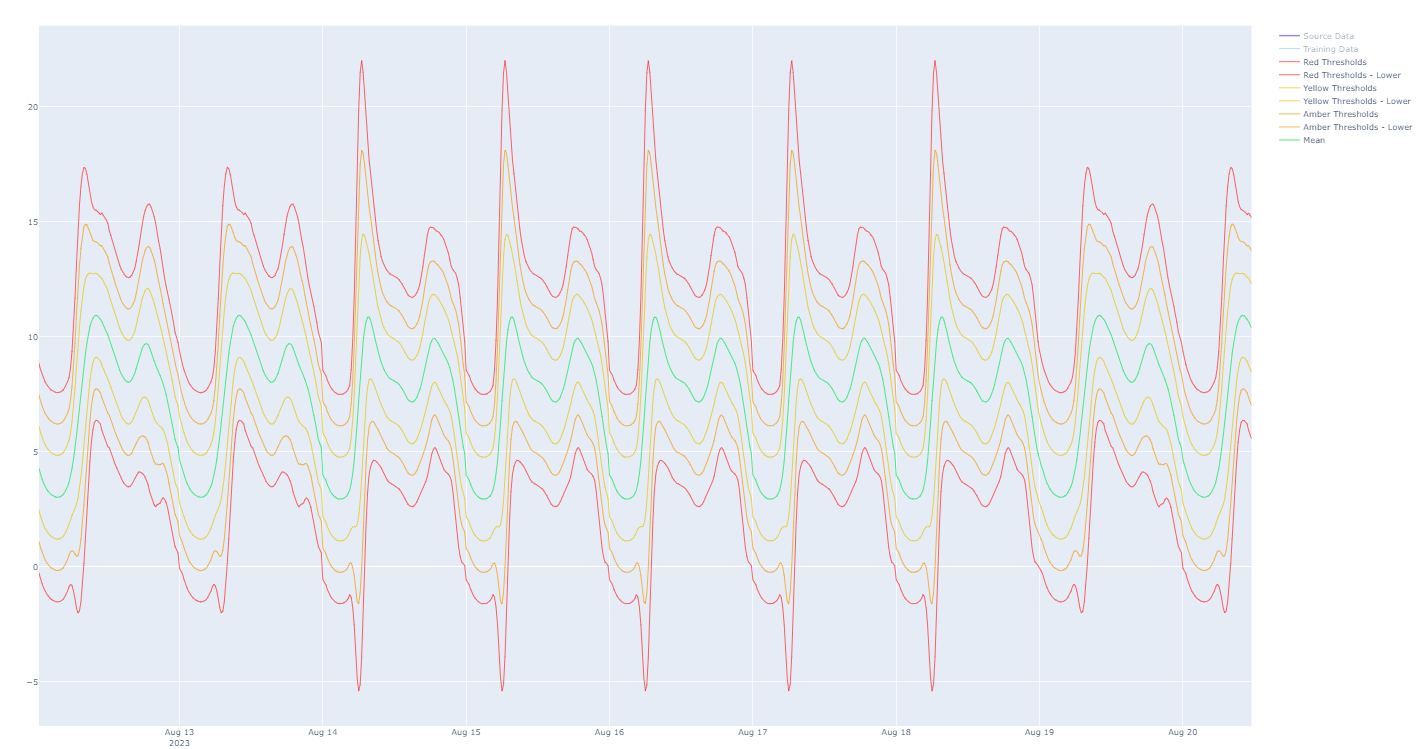

### Calculate z-scores for live data according to the timestamp and day bucket it falls into
As live data points come in the data is put into the correct 15min bucket for weekday or weekend and then compared to the mean value for that bucket. The difference between the live value and the mean divided by the standard deviation is the z-score.
\begin{equation}
z_{pressure}(x) = (x-\bar{x}_{pressure})/\sigma_{pressure}
\end{equation}
\begin{equation}
z_{flow}(x) = (x-\bar{x}_{flow})/\sigma_{flow}
\end{equation}

### Give the live data a status (green, yellow, amber, red) according to the z-score based on z-score thresholds
The following code shows how the statuses are calculated based on z-score thresholds.
```python
yellow,amber,red = 1,2,3

def get_status(value: float) -> str:
  """Calculates the status based on alarm_bands
  """
    try:
        if abs(value) > red:
            return 'red'
        elif abs(value) > amber:
            return 'amber'
        elif abs(value) > yellow:
            return 'yellow'
        elif (abs(value) <= yellow) & (value !=0):
          return 'green'
        else:
          return 'grey'
    except:
        return 'grey'
```
### Aggregate flow and pressure z-scores by using a Euclidean distance
For measurement devices that have both flow and pressure sensors the z-scores are aggregated according to the following formula:
\begin{equation}
z_{device}(x) = \sqrt{z_{pressure}(x)^2 + z_{flow}(x)^2}
\end{equation}
this results in a higher z-score if both flow and pressure are abnormal and will never be less than the highest z-score.
The same method as above is then applied to give the device a status.

### Use the graph object to associate hydraulicly linked measurement devices to every pipe and calculate the distance the measurement device is away from the pipe
A shortest path algorithm is then used to search the graph object and create a table of all pipes and their hydraulically linked nodes with the shortest distances to the nodes. This table is then filtered for only nodes that are flow and pressure measuring devices that are within Xkm from the pipe.

### Create a pipe z-score with an exponentially decaying by distance weighted average of the associated measurement devices
The z-score for a pipe is the weighted average of the nearest 5 devices' z-scores. The weight, $W_i$, for the $i^{th}$ device is the exponentially decaying inverse of its distance from the pipe - scaled to 1000m with a decay of 0.5, by default. That is,

$\quad W_i\, =\, \exp\bigg(\dfrac{-0.5 \times dist_i}{1000}\bigg),$

where $dist_i$ is the distance in metres of the $i^{th}$ device from the pipe.

The pipe z-score, $z_{pipe}$, is then calculated as follows

$
z_{pipe}(x)\,=\, \dfrac{\Sigma_{i=1}^{n}\, z_{device}(x)_i \cdot W_i}{\Sigma_{i=1}^{n}\, W_i}, \quad 1 \leq n \leq 5,
$

where $i\in [1,n]$ denotes the $n$ nearest devices. 

Finally, the pipe z-score is used to compute the pipe status in the same way as above. 

## Possible improvements to this algorithm
### Improvements to the mean variance algorithm for flow and pressure data
- Instead of bucketing the data into time windows use Fourier transforms or dynamic harmonic regression to remove seasonality and then all data can be treated as part of a single distribution instead of having a distribution for every time bucket. This would allow for a clustering algorithm to be used to detect anomalous events which could help with the issue of historical data having multiple operating modes.
- Build up a more extensive event database so that 
  - more advanced analytics and ML can be used and/or
  - instead of just anomaly detection event identification with supervised learning could be done.

### Improvements to the pipe aggregation algorithm
- Use hydraulics like flow direction, speed and volume to better estimate location and severity of events.
- Comparison logic between devices to pinpoint events. E.g. if one device has a flow increase and the other has a decrease the burst is between them.